# Import modules

In [59]:
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import loguniform
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Import the pickle

In [70]:
df_arbres = pd.read_pickle('./data/arbres.pkl')

In [71]:
# df_arbres = df_arbres.drop('code_parent', axis=1)
df_arbres = df_arbres.drop(['code_parent', 'collectivite', 'portarbre', 'adr_secteur'], axis=1)

In [72]:
df_arbres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29526 entries, 0 to 31666
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sous_categorie        29526 non-null  object 
 1   genre_bota            29486 non-null  object 
 2   espece                28313 non-null  object 
 3   stadededeveloppement  27018 non-null  object 
 4   anneedeplantation     29526 non-null  float64
 5   hauteurarbre          23738 non-null  object 
 6   latitude              29526 non-null  float64
 7   longitude             29526 non-null  float64
dtypes: float64(3), object(5)
memory usage: 2.0+ MB


# Split the data frame into testing and training sets

In [73]:
pred_col = 'anneedeplantation'

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df_arbres.drop(pred_col, axis=1),
                                                    df_arbres[pred_col], 
                                                    test_size=0.25, 
                                                    random_state=42)

# Create pipeline

In [111]:
# Colonnes à traiter
num_cols = ['latitude', 'longitude']
cat_cols = ['sous_categorie', 'genre_bota', 'espece', 
           'stadededeveloppement', 'hauteurarbre']

# Pipelines pour chaque type
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Fusion dans un seul transformateur
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

## Linear Regression

In [76]:
model1 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LinearRegression())
])

In [77]:
model1.fit(X_train, y_train)
y_pred_test = model1.predict(X_test)
y_pred_train = model1.predict(X_train)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred_test):.2f}")

Mean squared error: 160.32
Coefficient of determination: 0.51


In [78]:
print('-'*35)
print('Prediction for the training data')
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('-'*35)
print('Prediction for the test data')
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('-'*35)

-----------------------------------
Prediction for the training data
MSE: 154.89916102795624
RMSE: 12.445849148529652
-----------------------------------
Prediction for the test data
MSE: 160.32176718344658
RMSE: 12.661823217192957
-----------------------------------


In [79]:
cv_scores = cross_val_score(model1, X_train, y_train, cv=5, scoring='neg_mean_squared_error') 

print('-'*35)
print('Prediction for the training data')
print('mean MSE:',np.mean(-cv_scores))
print('std MSE:',np.std(-cv_scores))
print('mean RMSE:',np.sqrt(np.mean(-cv_scores)))

model1.fit(X_train, y_train)

# predict y values for testing data set
y_pred_test = model1.predict(X_test)

# evaluate MSE
print('-'*35)
print('Prediction for the test data')
mse_test = mean_squared_error(y_test, y_pred_test)
print('test MSE: {0}'.format(mse_test))
print('test RMSE: {0}'.format(np.sqrt(mse_test)))
print('-'*35)

-----------------------------------
Prediction for the training data
mean MSE: 164.00568267252515
std MSE: 4.83598588668096
mean RMSE: 12.806470344030206
-----------------------------------
Prediction for the test data
test MSE: 160.32176718344658
test RMSE: 12.661823217192957
-----------------------------------


## GridSearchCV lasso

In [80]:
model_lasso = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', Lasso(max_iter=10000))
])

In [81]:
param_grid = {"classifier__alpha": loguniform.rvs(0.0001, 10000, size=100, random_state=42)}

gs_lasso = GridSearchCV(model_lasso, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_lasso.fit(X_train, y_train)

gs_lasso_results = pd.DataFrame(gs_lasso.cv_results_)
gs_lasso_results = gs_lasso_results.sort_values('param_classifier__alpha')

print("Meilleurs paramètres :", gs_lasso.best_params_)

Meilleurs paramètres : {'classifier__alpha': np.float64(0.0006044730070370807)}


In [ ]:
gs_lasso_results['RMSE Train'] = np.sqrt(-gs_lasso_results['mean_test_score'])

for ind, val in enumerate(gs_lasso_results.index):
    par = gs_lasso_results.loc[ind, 'params']['classifier__alpha']
    model_l = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', Lasso(alpha=par))
    ])
    model_l.fit(X_train, y_train)
    y_pred_test = model_l.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    gs_lasso_results.loc[ind, 'RMSE Test'] = np.sqrt(mse_test)


In [95]:
gs_lasso_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,RMSE Train,RMSE Test
72,55.406329,2.147961,0.022615,0.015623,0.000111,{'classifier__alpha': 0.00011070747281639221},-168.849107,-155.574200,-153.511162,-164.223511,...,-167.357749,-153.223597,-159.002631,-177.941898,-161.350300,-162.442666,7.310720,21,12.745300,12.647445
10,39.366882,1.186328,0.014861,0.001623,0.000146,{'classifier__alpha': 0.00014610865886287216},-168.627056,-155.439314,-153.467692,-163.925691,...,-167.262709,-153.058849,-159.024500,-177.424937,-161.220940,-162.300844,7.211220,20,12.739735,12.643927
98,36.262023,6.396760,0.013486,0.001016,0.000160,{'classifier__alpha': 0.00015971768764426244},-168.571335,-155.382745,-153.455695,-163.811438,...,-167.229733,-153.006012,-159.031418,-177.228772,-161.165602,-162.251166,7.175971,19,12.737785,12.642581
42,33.231960,1.519052,0.015546,0.002341,0.000188,{'classifier__alpha': 0.00018841183049085134},-168.470837,-155.246995,-153.437931,-163.589849,...,-167.170362,-152.895504,-159.050002,-176.829392,-161.058209,-162.156506,7.109776,18,12.734069,12.640263
58,26.127324,1.339379,0.015847,0.002364,0.000230,{'classifier__alpha': 0.0002300479202014584},-168.336507,-155.061582,-153.421860,-163.288844,...,-167.093005,-152.730425,-159.090974,-176.289341,-160.928237,-162.018400,7.021192,15,12.728645,12.637485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.126438,0.017975,0.018452,0.004813,4033.800833,{'classifier__alpha': 4033.8008326003933},-335.050027,-324.699428,-331.551261,-325.480978,...,-329.710161,-323.800778,-338.317735,-339.273113,-330.016956,-331.086677,5.168242,61,18.195787,18.111667
34,0.132133,0.033889,0.019454,0.006147,5309.532269,{'classifier__alpha': 5309.5322690092235},-335.050027,-324.699428,-331.551261,-325.480978,...,-329.710161,-323.800778,-338.317735,-339.273113,-330.016956,-331.086677,5.168242,61,18.195787,18.111667
50,0.114879,0.014635,0.017719,0.003754,5710.537951,{'classifier__alpha': 5710.5379511268075},-335.050027,-324.699428,-331.551261,-325.480978,...,-329.710161,-323.800778,-338.317735,-339.273113,-330.016956,-331.086677,5.168242,61,18.195787,18.111667
11,0.123639,0.037756,0.016081,0.003037,5744.851636,{'classifier__alpha': 5744.851636320435},-335.050027,-324.699428,-331.551261,-325.480978,...,-329.710161,-323.800778,-338.317735,-339.273113,-330.016956,-331.086677,5.168242,61,18.195787,18.111667


In [137]:
gs_lasso_results[['params', 'RMSE Train', 'RMSE Test']].sort_values(by=['RMSE Train', 'RMSE Test']).head(25)

,params,RMSE Train,RMSE Test
37,{'classifier__alpha': 0.0006044730070370807},12.700103,12.636385
99,{'classifier__alpha': 0.0007296782748701785},12.700480,12.639152
56,{'classifier__alpha': 0.0005104344952682508},12.701757,12.634153
79,{'classifier__alpha': 0.0008451863533931648},12.703024,12.643115
90,{'classifier__alpha': 0.0009052196389541902},12.704908,12.645664
40,{'classifier__alpha': 0.000946903842177445},12.706010,12.647335
68,{'classifier__alpha': 0.00039482545946332466},12.709691,12.632174
77,{'classifier__alpha': 0.00039116250066838345},12.710004,12.632119
32,{'classifier__alpha': 0.0003314459707751232},12.715930,12.632196
83,{'classifier__alpha': 0.00032245328248123556},12.716957,12.632557


<Axes: >

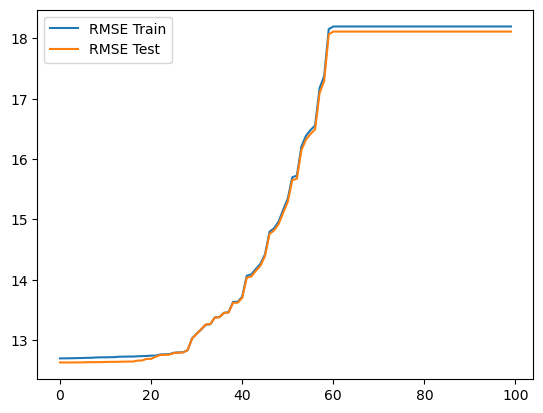

In [136]:
fig, ax = plt.subplots()
gs_lasso_results.sort_values(by=['RMSE Train', 'RMSE Test'])[['RMSE Train']].reset_index(drop=True).plot(ax=ax)
gs_lasso_results.sort_values(by=['RMSE Test', 'RMSE Test'])[['RMSE Test']].reset_index(drop=True).plot(ax=ax)

In [148]:
gs_lasso_results['Percent Difference'] = np.abs(gs_lasso_results['RMSE Train']-gs_lasso_results['RMSE Test']) / gs_lasso_results['RMSE Train'] * 100

In [149]:
gs_lasso_results.sort_values(by='Percent Difference')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,RMSE Train,RMSE Test,Percent Difference
13,0.845537,0.289796,0.014928,0.001518,0.004997,{'classifier__alpha': 0.004997040685255816},-167.750480,-156.308403,-160.971153,-167.447094,...,-155.028197,-164.293348,-177.529077,-163.232523,-164.727542,6.166275,29,12.834623,12.834981,0.002792
22,0.642635,0.209102,0.017641,0.007887,0.021735,{'classifier__alpha': 0.02173487707341741},-177.912692,-168.561194,-172.199119,-178.244801,...,-166.045430,-177.647891,-189.752709,-171.741540,-175.956037,6.344786,34,13.264842,13.268088,0.024473
84,0.455162,0.131749,0.015101,0.001415,0.030751,{'classifier__alpha': 0.030750952591044503},-182.655081,-174.621966,-176.564725,-182.780218,...,-171.121681,-183.118132,-195.296134,-176.238337,-181.055768,6.436963,37,13.455696,13.452333,0.025000
44,0.567404,0.149071,0.016079,0.002077,0.011755,{'classifier__alpha': 0.011755466083160767},-172.464267,-161.440573,-166.903755,-172.508362,...,-159.774571,-170.394317,-183.497428,-166.210484,-169.828070,6.396205,30,13.031810,13.028384,0.026291
16,0.443729,0.135538,0.016318,0.005342,0.027161,{'classifier__alpha': 0.027160511446548512},-180.831523,-172.236956,-174.825452,-180.958787,...,-168.973520,-180.874376,-193.033784,-174.323324,-178.998377,6.409494,35,13.379027,13.375489,0.026452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,26.127324,1.339379,0.015847,0.002364,0.000230,{'classifier__alpha': 0.0002300479202014584},-168.336507,-155.061582,-153.421860,-163.288844,...,-152.730425,-159.090974,-176.289341,-160.928237,-162.018400,7.021192,15,12.728645,12.637485,0.716176
42,33.231960,1.519052,0.015546,0.002341,0.000188,{'classifier__alpha': 0.00018841183049085134},-168.470837,-155.246995,-153.437931,-163.589849,...,-152.895504,-159.050002,-176.829392,-161.058209,-162.156506,7.109776,18,12.734069,12.640263,0.736648
98,36.262023,6.396760,0.013486,0.001016,0.000160,{'classifier__alpha': 0.00015971768764426244},-168.571335,-155.382745,-153.455695,-163.811438,...,-153.006012,-159.031418,-177.228772,-161.165602,-162.251166,7.175971,19,12.737785,12.642581,0.747414
10,39.366882,1.186328,0.014861,0.001623,0.000146,{'classifier__alpha': 0.00014610865886287216},-168.627056,-155.439314,-153.467692,-163.925691,...,-153.058849,-159.024500,-177.424937,-161.220940,-162.300844,7.211220,20,12.739735,12.643927,0.752036


In [102]:
y_pred_test = gs_lasso.best_estimator_.predict(X_test)
y_pred_train = gs_lasso.best_estimator_.predict(X_train)

print('-'*35)
print('Prediction for the training data')
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('-'*35)
print('Prediction for the test data')
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('-'*35)

-----------------------------------
Prediction for the training data
MSE: 155.7239050817016
RMSE: 12.47893845972892
-----------------------------------
Prediction for the test data
MSE: 159.67822258014667
RMSE: 12.6363848698964
-----------------------------------


## GridSearchCV ridge

In [18]:
model_ridge = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', Ridge(max_iter=10000))
])

In [19]:
param_grid = {"classifier__alpha": loguniform.rvs(0.0001, 10000, size=100, random_state=42)}

gs_ridge = GridSearchCV(model_ridge, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_ridge.fit(X_train, y_train)

gs_ridge_results = pd.DataFrame(gs_ridge.cv_results_)
gs_ridge_results = gs_ridge_results.sort_values('param_classifier__alpha')

print("Meilleurs paramètres :", gs_ridge.best_params_)

Meilleurs paramètres : {'classifier__alpha': np.float64(29.775853025212687)}


In [20]:
gs_ridge_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
72,0.080062,0.006080,0.013307,0.001170,0.000111,{'classifier__alpha': 0.00011070747281639221},-283.314115,-274.849744,-282.754428,-273.529683,-283.864351,-281.522509,-277.109665,-289.034287,-289.447931,-273.558245,-280.898496,5.629127,73
10,0.083916,0.006744,0.013819,0.002136,0.000146,{'classifier__alpha': 0.00014610865886287216},-283.314115,-274.849744,-282.754428,-273.529683,-283.864351,-281.522509,-277.109665,-289.034287,-289.447931,-273.558245,-280.898496,5.629127,72
98,0.082577,0.008405,0.014346,0.001500,0.000160,{'classifier__alpha': 0.00015971768764426244},-283.314115,-274.849744,-282.754428,-273.529683,-283.864351,-281.522509,-277.109665,-289.034287,-289.447931,-273.558245,-280.898496,5.629127,71
42,0.084816,0.006294,0.013811,0.001316,0.000188,{'classifier__alpha': 0.00018841183049085134},-283.314115,-274.849744,-282.754428,-273.529683,-283.864351,-281.522509,-277.109665,-289.034287,-289.447931,-273.558245,-280.898496,5.629127,70
58,0.081382,0.004342,0.014436,0.001424,0.000230,{'classifier__alpha': 0.0002300479202014584},-283.314115,-274.849744,-282.754428,-273.529683,-283.864351,-281.522509,-277.109665,-289.034287,-289.447931,-273.558245,-280.898496,5.629127,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.116235,0.018771,0.016049,0.002990,4033.800833,{'classifier__alpha': 4033.8008326003933},-285.895321,-276.641892,-284.859806,-276.526216,-287.074676,-283.522095,-278.098029,-290.934478,-290.784618,-276.675292,-283.101242,5.463860,96
34,0.082821,0.006166,0.013543,0.000603,5309.532269,{'classifier__alpha': 5309.5322690092235},-287.042162,-277.662056,-285.861042,-277.702808,-288.219268,-284.496720,-278.840378,-291.784563,-291.638018,-277.905282,-284.115230,5.414467,97
50,0.084105,0.006275,0.015568,0.002223,5710.537951,{'classifier__alpha': 5710.5379511268075},-287.406942,-277.993078,-286.181938,-278.072538,-288.577294,-284.809532,-279.086275,-292.057168,-291.918407,-278.292974,-284.439615,5.399948,98
11,0.080204,0.003831,0.013597,0.002136,5744.851636,{'classifier__alpha': 5744.851636320435},-287.438180,-278.021542,-286.209465,-278.104120,-288.607855,-284.836374,-279.107514,-292.080563,-291.942584,-278.326114,-284.467431,5.398728,99


In [21]:
y_pred_test = gs_ridge.best_estimator_.predict(X_test)
y_pred_train = gs_ridge.best_estimator_.predict(X_train)

print('-'*35)
print('Prediction for the training data')
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('-'*35)
print('Prediction for the test data')
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('-'*35)

-----------------------------------
Prediction for the training data
MSE: 280.8485138387632
RMSE: 16.75853555173492
-----------------------------------
Prediction for the test data
MSE: 280.25961428782756
RMSE: 16.74095619395223
-----------------------------------


## Decision Tree

In [166]:
model_dt = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', DecisionTreeRegressor())
])

In [ ]:
param_grid = {"classifier__criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              "classifier__splitter" : ['best', 'random'],
              'classifier__random_state' : [42]}

gs_dt = GridSearchCV(model_dt, param_grid, cv=10, scoring='neg_mean_squared_error')
gs_dt.fit(X_train, y_train)

gs_dt_results = pd.DataFrame(gs_dt.cv_results_)

print("Meilleurs paramètres :", gs_dt.best_params_)

KeyError: 'param_classifier__alpha'

In [168]:
gs_dt_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__random_state,param_classifier__splitter,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.138683,0.022736,0.008813,0.001324,squared_error,42,best,"{'classifier__criterion': 'squared_error', 'cl...",-102.942212,-100.670880,...,-93.566591,-87.892954,-88.491870,-107.335140,-96.709575,-110.677507,-95.344625,-98.548418,7.156731,6
1,0.062450,0.001520,0.008583,0.001145,squared_error,42,random,"{'classifier__criterion': 'squared_error', 'cl...",-92.490293,-93.135440,...,-93.793228,-89.037489,-92.670280,-110.729901,-109.995032,-98.140018,-87.422313,-97.193499,7.964342,2
2,0.138993,0.017133,0.008575,0.000842,friedman_mse,42,best,"{'classifier__criterion': 'friedman_mse', 'cla...",-102.942212,-100.670880,...,-93.566591,-87.892954,-88.491870,-107.335140,-96.709575,-110.677507,-95.344625,-98.548418,7.156731,6
3,0.073788,0.011814,0.009178,0.001619,friedman_mse,42,random,"{'classifier__criterion': 'friedman_mse', 'cla...",-97.490293,-103.790068,...,-98.125959,-94.451671,-97.147245,-103.545167,-106.038392,-91.427733,-88.520777,-97.602038,5.294191,4
4,9.255598,0.333542,0.008114,0.000849,absolute_error,42,best,"{'classifier__criterion': 'absolute_error', 'c...",-101.169752,-102.185553,...,-101.214447,-101.881662,-92.123758,-104.989612,-109.344173,-91.775519,-103.554652,-101.585493,5.463933,8
5,3.928208,0.253822,0.008333,0.000734,absolute_error,42,random,"{'classifier__criterion': 'absolute_error', 'c...",-101.602257,-104.461851,...,-88.596840,-85.826558,-92.329268,-109.771454,-100.736676,-94.514905,-92.629630,-97.897418,7.879015,5
6,0.144861,0.002629,0.008296,0.000381,poisson,42,best,"{'classifier__criterion': 'poisson', 'classifi...",-103.809932,-99.744018,...,-98.288939,-88.372177,-83.727642,-103.564589,-98.411021,-109.925926,-91.405149,-97.565797,7.405475,3
7,0.068399,0.001676,0.008172,0.000701,poisson,42,random,"{'classifier__criterion': 'poisson', 'classifi...",-96.175169,-95.269526,...,-96.492099,-86.813460,-75.786811,-107.929088,-85.073622,-104.366305,-82.385727,-92.460151,9.425265,1


In [169]:
print("Meilleurs paramètres :", gs_dt.best_params_)

Meilleurs paramètres : {'classifier__criterion': 'poisson', 'classifier__random_state': 42, 'classifier__splitter': 'random'}


In [ ]:
y_pred_test = gs_dt.best_estimator_.predict(X_test)
y_pred_train = gs_dt.best_estimator_.predict(X_train)

print(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print(np.sqrt(mean_squared_error(y_train, y_pred_train)))

9.819675977573013
0.0


## Random Forest

In [31]:
model_rf = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor())
])

In [32]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'rf__n_estimators': n_estimators, 'rf__max_features': max_features, 
               'rf__max_depth': max_depth, 'rf__min_samples_split': min_samples_split, 
               'rf__min_samples_leaf': min_samples_leaf, 'rf__bootstrap': bootstrap}


In [ ]:
gs_rf = RandomizedSearchCV(model_rf, random_grid, cv=3, n_iter=50,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

gs_rf.fit(X_train, y_train)

gs_rf_results = pd.DataFrame(gs_rf.cv_results_)

print("Meilleurs paramètres :", gs_rf.best_params_)

/home/alicia.clark@Digital-Grenoble.local/miniconda3/envs/07_stats/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/alicia.clark@Digital-Grenoble.local/miniconda3/envs/07_stats/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "/home/alicia.clark@Digital-Grenoble.local/miniconda3/envs/07_stats/lib/python3.13/site-packages/sklearn/model_sele

Meilleurs paramètres : {'rf__n_estimators': 600, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 50, 'rf__bootstrap': False}


In [35]:
gs_rf_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__bootstrap,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.091154,0.006357,0.000000,0.000000,800,10,2,auto,None,True,...,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN
1,0.103436,0.016420,0.000000,0.000000,600,5,4,auto,30,False,...,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN
2,72.907478,2.228070,2.974079,0.376714,1800,2,4,sqrt,50,False,...,-72.573627,-80.369999,-75.801871,3.320875,14,-32.513184,-33.032827,-32.311875,-32.619295,0.303741
3,0.093761,0.011561,0.000000,0.000000,400,10,1,auto,None,True,...,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN
4,53.460412,2.716277,5.152800,1.601577,1800,5,2,sqrt,30,True,...,-70.777739,-78.237957,-73.859308,3.180725,10,-29.530803,-30.003016,-29.591146,-29.708322,0.209832
5,0.133750,0.024569,0.000000,0.000000,1800,10,4,auto,80,True,...,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN
6,16.783387,0.918517,0.951145,0.262031,600,10,4,sqrt,40,True,...,-86.073622,-93.666676,-88.828139,3.432295,23,-55.299722,-55.888949,-54.881701,-55.356791,0.413182
7,0.114242,0.009214,0.000000,0.000000,800,5,1,auto,None,True,...,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN
8,0.157920,0.019092,0.000000,0.000000,200,2,2,auto,100,True,...,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN
9,0.153879,0.039011,0.000000,0.000000,1600,10,4,auto,40,True,...,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN


In [40]:
# # Get the best hyperparameters and model
# best_params = gs_rf.best_params_
# best_model = gs_rf.best_estimator_

# # Evaluate the best model
# y_pred_test = gs_rf.best_estimator_.predict(X_test)
# y_pred_train = gs_rf.best_estimator_.predict(X_train)

y_pred_test = gs_rf.predict(X_test)
y_pred_train = gs_rf.predict(X_train)

print('-'*35)
print('Prediction for the training data')
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('-'*35)
print('Prediction for the test data')
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('-'*35)
print(f"Best Hyperparameters: {best_params}")

-----------------------------------
Prediction for the training data
MSE: 7.348688544396557e-05
RMSE: 0.008572449209179694
-----------------------------------
Prediction for the test data
MSE: 51.4171494129581
RMSE: 7.170575249793988
-----------------------------------
Best Hyperparameters: {'rf__n_estimators': 600, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 50, 'rf__bootstrap': False}


## High gradient boosting regression

In [112]:
model_hgb = Pipeline([
    ('preprocessing', preprocessor),
    ('hgb', HistGradientBoostingRegressor())
])

In [120]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_leaf = [20, 50, 100]
learning_rate = [0.1, 0.5, 1]

random_grid = {'hgb__learning_rate': learning_rate, 'hgb__max_depth': max_depth, 
               'hgb__min_samples_leaf': min_samples_leaf}


In [121]:
gs_hgb = RandomizedSearchCV(model_hgb, random_grid, cv=3, n_iter=50,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

gs_hgb.fit(X_train, y_train)

gs_hgb_results = pd.DataFrame(gs_hgb.cv_results_)

print("Meilleurs paramètres :", gs_hgb.best_params_)

Meilleurs paramètres : {'hgb__min_samples_leaf': 20, 'hgb__max_depth': 50, 'hgb__learning_rate': 0.5}


In [122]:
gs_hgb_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hgb__min_samples_leaf,param_hgb__max_depth,param_hgb__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,16.370467,0.740566,1.013998,0.125348,100,70,0.1,"{'hgb__min_samples_leaf': 100, 'hgb__max_depth...",-118.095808,-116.091712,-122.981282,-119.056267,2.893487,47,-106.786640,-106.119842,-105.985466,-106.297316,0.350326
1,13.061744,1.534932,0.795798,0.059678,50,40,1.0,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-89.442763,-92.739891,-89.526562,-90.569739,1.534911,21,-46.725988,-55.087077,-47.950103,-49.921056,3.686954
2,16.952135,0.379701,0.746443,0.172512,100,80,1.0,"{'hgb__min_samples_leaf': 100, 'hgb__max_depth...",-95.605825,-92.378707,-96.977252,-94.987261,1.927627,33,-55.507308,-56.561984,-55.586278,-55.885190,0.479651
3,16.777304,0.735989,1.011763,0.116732,50,60,0.1,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-107.632711,-109.144067,-114.893782,-110.556853,3.128127,40,-97.979982,-98.693012,-96.922658,-97.865218,0.727286
4,14.391969,1.087846,0.810492,0.126350,20,70,1.0,"{'hgb__min_samples_leaf': 20, 'hgb__max_depth'...",-89.890414,-84.250956,-90.811682,-88.317684,2.900103,16,-38.952733,-39.260399,-40.115815,-39.442983,0.492065
5,14.675765,1.677785,0.797755,0.147466,100,30,0.5,"{'hgb__min_samples_leaf': 100, 'hgb__max_depth...",-94.844921,-89.939159,-94.620837,-93.134972,2.261632,25,-65.580370,-66.769138,-65.788026,-66.045845,0.518424
6,16.004059,0.541171,0.943380,0.134348,100,20,0.1,"{'hgb__min_samples_leaf': 100, 'hgb__max_depth...",-118.989387,-116.316870,-122.195452,-119.167236,2.403214,48,-106.962419,-106.302781,-105.517587,-106.260929,0.590592
7,15.592267,0.725672,0.672877,0.087158,100,30,1.0,"{'hgb__min_samples_leaf': 100, 'hgb__max_depth...",-95.573017,-91.100114,-96.290656,-94.321263,2.296461,30,-54.970283,-56.698221,-56.447609,-56.038704,0.762384
8,18.510480,2.352858,1.352450,0.359617,50,50,0.1,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-108.129386,-108.347833,-113.712998,-110.063406,2.582192,38,-97.883598,-96.954374,-95.613427,-96.817133,0.931860
9,18.151499,2.509378,1.424019,0.646584,20,60,0.1,"{'hgb__min_samples_leaf': 20, 'hgb__max_depth'...",-103.641262,-103.501540,-110.604058,-105.915620,3.315717,37,-92.502163,-91.526325,-91.423947,-91.817478,0.485946


In [123]:
gs_hgb_results['RMSE Train'] = np.sqrt(-gs_hgb_results['mean_test_score'])

for ind, val in enumerate(gs_hgb_results.index):
    learning_rate = gs_hgb_results.loc[ind, 'params']['hgb__learning_rate']
    max_depth = gs_hgb_results.loc[ind, 'params']['hgb__max_depth']
    min_leaf = gs_hgb_results.loc[ind, 'params']['hgb__min_samples_leaf']
    model_hgb = Pipeline([
        ('preprocessing', preprocessor),
        ('hgb', HistGradientBoostingRegressor(learning_rate=learning_rate, max_depth=max_depth, min_samples_leaf=min_leaf))
    ])
    model_hgb.fit(X_train, y_train)
    y_pred_test = model_hgb.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    gs_hgb_results.loc[ind, 'RMSE Test'] = np.sqrt(mse_test)


In [141]:
gs_hgb_results[['params', 'RMSE Train', 'RMSE Test']].sort_values(by=['RMSE Train', 'RMSE Test']).reset_index(drop=True).loc[35:36, 'params'].values

array([{'hgb__min_samples_leaf': 20, 'hgb__max_depth': 40, 'hgb__learning_rate': 0.1},
       {'hgb__min_samples_leaf': 20, 'hgb__max_depth': 60, 'hgb__learning_rate': 0.1}],
      dtype=object)

In [142]:
gs_hgb_results['Percent Difference'] = (gs_hgb_results['RMSE Train']-gs_hgb_results['RMSE Test']) / gs_hgb_results['RMSE Train'] * 100

In [144]:
gs_hgb_results.sort_values('Percent Difference')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hgb__min_samples_leaf,param_hgb__max_depth,param_hgb__learning_rate,params,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,RMSE Train,RMSE Test,Percent Difference
9,18.151499,2.509378,1.424019,0.646584,20,60,0.1,"{'hgb__min_samples_leaf': 20, 'hgb__max_depth'...",-103.641262,-103.501540,...,3.315717,37,-92.502163,-91.526325,-91.423947,-91.817478,0.485946,10.291531,10.020195,2.636506
44,20.009137,5.304363,1.786601,0.697199,20,40,0.1,"{'hgb__min_samples_leaf': 20, 'hgb__max_depth'...",-103.277322,-103.704007,...,3.349928,36,-92.182908,-91.784944,-90.245237,-91.404363,0.835573,10.288645,9.996431,2.840161
32,14.028815,1.569599,1.908877,1.388129,20,10,0.1,"{'hgb__min_samples_leaf': 20, 'hgb__max_depth'...",-112.033787,-111.864998,...,1.705274,45,-101.299399,-100.483369,-96.563112,-99.448627,2.067385,10.637397,10.263446,3.515439
18,18.895908,1.965182,1.300999,0.364622,50,20,0.1,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-109.928151,-109.191827,...,2.061343,44,-98.933544,-97.495792,-96.230155,-97.553164,1.104399,10.535749,10.151536,3.646753
37,20.009868,0.878543,2.005419,0.472634,50,10,0.1,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-116.913659,-117.035164,...,2.797572,46,-107.676219,-107.381333,-104.917994,-106.658516,1.236608,10.906525,10.479342,3.916766
3,16.777304,0.735989,1.011763,0.116732,50,60,0.1,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-107.632711,-109.144067,...,3.128127,40,-97.979982,-98.693012,-96.922658,-97.865218,0.727286,10.514602,10.094985,3.990803
38,19.296410,2.981487,1.886622,0.834225,50,30,0.1,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-108.026946,-109.903421,...,2.586114,42,-97.546179,-97.733800,-96.373781,-97.217920,0.601791,10.521966,10.097854,4.030735
8,18.510480,2.352858,1.352450,0.359617,50,50,0.1,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-108.129386,-108.347833,...,2.582192,38,-97.883598,-96.954374,-95.613427,-96.817133,0.931860,10.491111,10.066745,4.045006
10,19.307238,2.425403,1.127819,0.497460,50,110,0.1,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-108.823218,-108.355439,...,2.584107,39,-99.448686,-98.679045,-95.569458,-97.899063,1.676978,10.507691,10.075853,4.109729
31,17.483939,1.667745,1.110265,0.278970,50,80,0.1,"{'hgb__min_samples_leaf': 50, 'hgb__max_depth'...",-108.290583,-109.586584,...,2.749644,43,-98.761935,-98.090938,-97.088528,-97.980467,0.687617,10.528368,10.088361,4.179259


<Axes: >

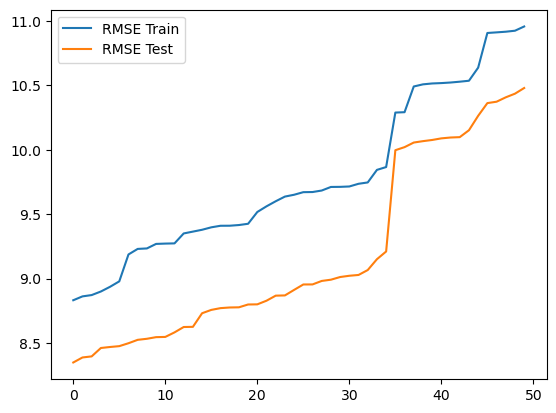

In [135]:
fig, ax = plt.subplots()
gs_hgb_results.sort_values(by=['RMSE Train', 'RMSE Test'])[['RMSE Train']].reset_index(drop=True).plot(ax=ax)
gs_hgb_results.sort_values(by=['RMSE Test', 'RMSE Test'])[['RMSE Test']].reset_index(drop=True).plot(ax=ax)

In [125]:
gs_hgb.fit(X_train, y_train)
y_pred_test = gs_hgb.predict(X_test)
y_pred_train = gs_hgb.predict(X_train)

print('-'*35)
print('Prediction for the training data')
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('-'*35)
print('Prediction for the test data')
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('-'*35)

-----------------------------------
Prediction for the training data
MSE: 48.74315742850899
RMSE: 6.981629997966735
-----------------------------------
Prediction for the test data
MSE: 70.10140133889402
RMSE: 8.372657961417868
-----------------------------------


## Dummy classifier

In [93]:
model_d = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

In [113]:
model_d.fit(X_train, y_train)
y_pred_test = model_d.predict(X_test)
y_pred_train = model_d.predict(X_train)

# Calculate and print the model's accuracy on the test data
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)*100:.4f}%")
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print(np.sqrt(mean_squared_error(y_train, y_pred_train)))

Accuracy: 11.4061%
23.84445383873398
23.852532894973237


Scratch work

In [18]:
# le = LabelEncoder()
# for col in col_cat:
#     df_explore[col] = le.fit_transform(df_explore[col])

In [19]:
# enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# test = enc.fit(df_explore[col_num])

# # Create an encoder 
# encoder= OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
 
# # Train encoder using multiple columns
# encoder.fit(df_explore[col_num]) 
 
# # Get encoded column names 
# encoded_columns=encoder.get_feature_names_out() 
 
# # Transform data using the trained encoder 
# encoded_data = encoder.transform(df_explore[col_num]) 
 
# # Create a dataframe using the encoded data 
# encoded_df=pd.DataFrame(encoded_data, columns=encoded_columns) 
# encoded_df